In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Clone the repository if not already present
repo_url = "https://github.com/iikka-v/ML-NDT.git"
repo_dir = "ML-NDT"

if not os.path.exists(repo_dir):
    os.system(f"git clone {repo_url}")
# Walk through all folders and files in the repository
for root, dirs, files in os.walk(repo_dir):
    print(f"\nDirectory: {root}")
    for file in files:
        print(f"  - {file}")


Directory: ML-NDT
  - LICENSE
  - README.md
  - .gitignore

Directory: ML-NDT/.git
  - config
  - HEAD
  - description
  - index
  - packed-refs

Directory: ML-NDT/.git/objects

Directory: ML-NDT/.git/objects/pack
  - pack-c4f0bb6de4d230bacabad075baa18c3a0a067745.pack
  - pack-c4f0bb6de4d230bacabad075baa18c3a0a067745.idx

Directory: ML-NDT/.git/objects/info

Directory: ML-NDT/.git/info
  - exclude

Directory: ML-NDT/.git/logs
  - HEAD

Directory: ML-NDT/.git/logs/refs

Directory: ML-NDT/.git/logs/refs/heads
  - master

Directory: ML-NDT/.git/logs/refs/remotes

Directory: ML-NDT/.git/logs/refs/remotes/origin
  - HEAD

Directory: ML-NDT/.git/hooks
  - commit-msg.sample
  - pre-rebase.sample
  - pre-commit.sample
  - applypatch-msg.sample
  - fsmonitor-watchman.sample
  - pre-receive.sample
  - prepare-commit-msg.sample
  - post-update.sample
  - pre-merge-commit.sample
  - pre-applypatch.sample
  - pre-push.sample
  - update.sample
  - push-to-checkout.sample

Directory: ML-NDT/.git/ref

In [3]:
# List all files in the data directory
data_path = os.path.join(repo_dir, "data")
files = os.listdir(data_path)
print("Files/Folders in data directory:", files)

Files/Folders in data directory: ['training', 'validation']


In [4]:
training_data_path = os.path.join(data_path, 'training')
validation_data_path = os.path.join(data_path, 'validation')

In [5]:
print(training_data_path)

ML-NDT/data/training


In [6]:
# Function to count the total number of files and categorize by file type
def count_files_by_type(directory):
    file_types = {}
    total_files = 0
    for f in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, f)):
            total_files += 1
            extension = f.split('.')[-1]
            file_types[extension] = file_types.get(extension, 0) + 1
    return file_types, total_files

# Count files by type in both directories
training_file_types, training_files_count = count_files_by_type(training_data_path)
validation_file_types, validation_files_count = count_files_by_type(validation_data_path)

# Count the total files in both directories
total_files_count = training_files_count + validation_files_count

# Print the counts
print(f"Total files in 'training' directory: {training_files_count}")
print(f"Total files in 'validation' directory: {validation_files_count}")
print(f"Total files in both directories: {total_files_count}")

print("\nFile types and counts in 'training' directory:")
for file_type, count in training_file_types.items():
    print(f"{file_type}: {count}")

print("\nFile types and counts in 'validation' directory:")
for file_type, count in validation_file_types.items():
    print(f"{file_type}: {count}")


Total files in 'training' directory: 796
Total files in 'validation' directory: 8
Total files in both directories: 804

File types and counts in 'training' directory:
jsons: 199
labels: 199
bins: 199
meta: 199

File types and counts in 'validation' directory:
jsons: 2
labels: 2
bins: 2
meta: 2


In [7]:
# Choose the first .bins file in the training directory
first_bin_file = next((f for f in os.listdir(training_data_path) if f.endswith(".bins")), None)

if not first_bin_file:
    print("No .bins file found in the training directory.")
else:
    print(f"First .bins file: {first_bin_file}")

    # Get the corresponding .meta file
    meta_file = first_bin_file.replace(".bins", ".meta")
    meta_path = os.path.join(training_data_path, meta_file)

    if not os.path.exists(meta_path):
        print(f"No corresponding .meta file found for {first_bin_file}.")
    else:
        # Read the .meta file to get metadata about the .bins file
        with open(meta_path, "r") as f:
            meta_info = f.read().strip()
        
        print(f"Metadata from {meta_file}: {meta_info}")

        # Load the .bins file based on the meta information (assuming the format is UInt16, 256 x 256 x 100)
        shape = tuple(map(int, meta_info.split(",")[1].strip().split("x")))

        # Load the .bins file (reshape the data according to the shape)
        bin_path = os.path.join(training_data_path, first_bin_file)

        def load_bin_file(bin_file, shape, dtype=np.uint16):
            """Reads a binary UT data file and reshapes it into a 3D array."""
            with open(bin_file, 'rb') as f:
                raw_data = np.frombuffer(f.read(), dtype=dtype)
            return raw_data.reshape(shape)

        # Read the .bins file
        ut_data = load_bin_file(bin_path, shape)

        print(f"Data shape of {first_bin_file}: {ut_data.shape}")
        print("First few values in the data:", ut_data.flatten()[:10])  # Preview the first few values


First .bins file: 86A4B585-32A6-409A-BC5E-97347358F6F4.bins
Metadata from 86A4B585-32A6-409A-BC5E-97347358F6F4.meta: UInt16, 256 x 256 x 100
Data shape of 86A4B585-32A6-409A-BC5E-97347358F6F4.bins: (256, 256, 100)
First few values in the data: [ 73 166 238 320 209 120  27  45  46  55]


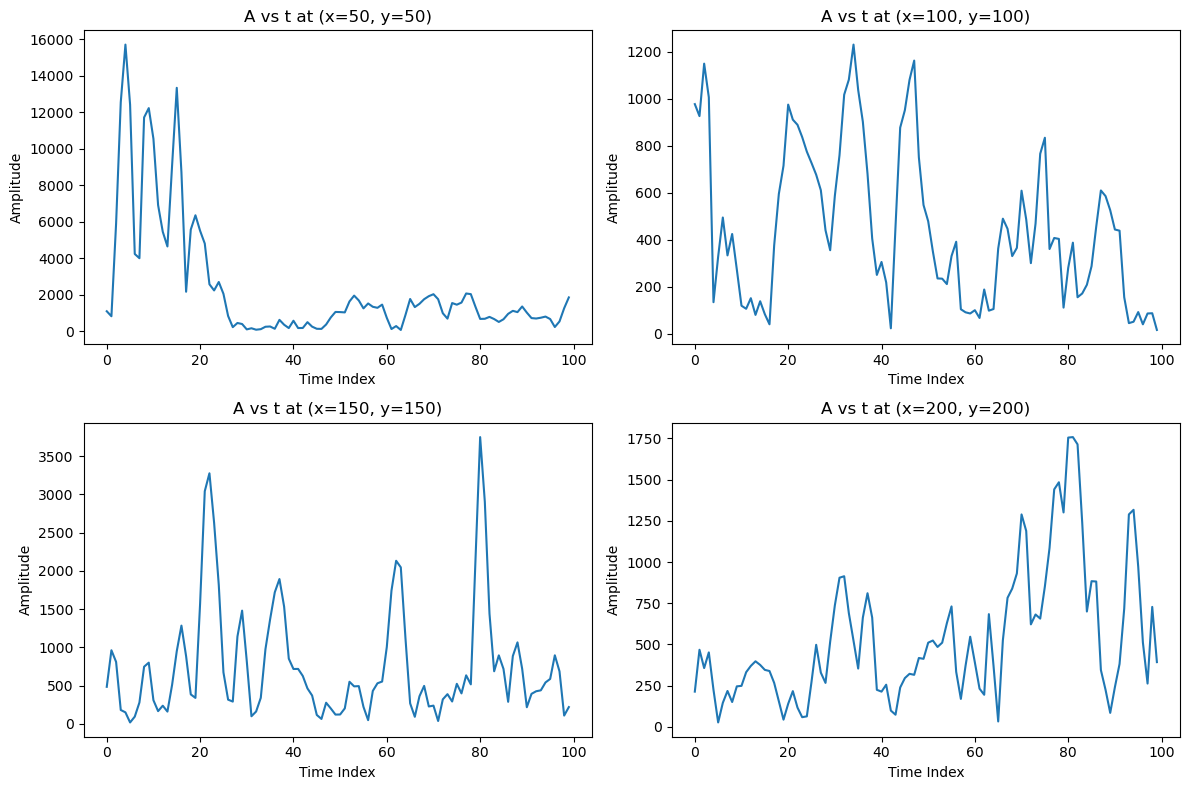

In [8]:
# Choose a few (x, y) locations to plot
coordinates = [(50, 50), (100, 100), (150, 150), (200, 200)]  # Example coordinates

# Loop through the selected coordinates and plot A vs t (Amplitude vs Time)
plt.figure(figsize=(12, 8))

for idx, (x, y) in enumerate(coordinates):
    # Extract the time series (A vs t) for each coordinate
    a_scan = ut_data[x, y, :]
    
    # Plotting the A vs t
    plt.subplot(2, 2, idx + 1)
    plt.plot(a_scan)
    plt.title(f"A vs t at (x={x}, y={y})")
    plt.xlabel("Time Index")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [9]:
# Get the corresponding .json file (assuming the json file follows the same naming pattern)
json_file = first_bin_file.replace(".bins", ".jsons")
json_path = os.path.join(training_data_path, json_file)

# Check if the .json file exists
if os.path.exists(json_path):
    print(f"Found .json file: {json_path}")
else:
    print(f"No corresponding .json file found for {first_bin_file}.")


Found .json file: ML-NDT/data/training/86A4B585-32A6-409A-BC5E-97347358F6F4.jsons


In [10]:
# Read the content of the .jsons file
try:
    with open(json_path, 'r') as file:
        content = file.read()

    # Add a wrapper to correctly parse multiple JSON objects (i.e., separate them properly)
    # We add a leading '[' and trailing ']' to make it a valid JSON array.
    fixed_content = '[' + content.replace('}{', '},{') + ']'

    # Parse the fixed JSON content
    flaws_data = json.loads(fixed_content)

    # Check for consistency in the features (sub-divisions)
    if flaws_data:
        first_flaw = flaws_data[0]['flaws'][0]
        feature_keys = first_flaw.keys()  # List of feature keys in the first flaw entry

        print(f"Features found in the first flaw: {feature_keys}")
        
        consistent = True
        for flaw_data in flaws_data:
            flaw = flaw_data['flaws'][0]
            if set(flaw.keys()) != set(feature_keys):
                print("Inconsistent features detected.")
                consistent = False
                break

        if consistent:
            print("All flaws have the same features.")
        else:
            print("Some flaws have inconsistent features.")

        # Show the count and ranges for each feature
        print("\nCount and Ranges for each feature:")
        feature_ranges = {key: [] for key in feature_keys}

        # Debugging step: Check data for each flaw
        for flaw_data in flaws_data:
            flaw = flaw_data['flaws'][0]
            for key in feature_keys:
                try:
                    value = flaw[key]

                    if isinstance(value, str) and '-' in value:  # Check if the value is a range (string with '-')
                        # Split the string range and convert to float
                        min_value, max_value = value.split('-')
                        feature_ranges[key].append((float(min_value), float(max_value)))  # Store as tuple of (min, max)
                    else:
                        # Convert other feature values (whether string or numeric) to float
                        feature_ranges[key].append(float(value))  # Convert to float for non-range features
                except ValueError:
                    print(f"Error converting {key} to float: {flaw[key]}")  # Error handling for conversion failures

        for key, values in feature_ranges.items():
            if values:
                print(f"{key}: Count = {len(values)}, Range = {min(values)} - {max(values)}")

except Exception as e:
    print(f"Error reading or analyzing the JSON file: {e}")


Features found in the first flaw: dict_keys(['location_min', 'noise_threshold', 'equivalent_flawsize', 'noise_flawsize', 'location', 'original_location', 'location_max', 'max_amplitude', 'factor', 'size'])
All flaws have the same features.

Count and Ranges for each feature:
location_min: Count = 100, Range = 12.564264782937757 - 4813.0
noise_threshold: Count = 100, Range = 804.0 - 1068.0
equivalent_flawsize: Count = 100, Range = 0.0 - 8.51817441923946
noise_flawsize: Count = 100, Range = 0.0 - 0.503911518748314
location: Count = 100, Range = (22.281938325991177, 646.1762114537441) - (4813.0, 4983.0)
original_location: Count = 100, Range = (454.0, 481.0) - (873.0, 895.0)
location_max: Count = 100, Range = 219.87463370141103 - 5021.0
max_amplitude: Count = 100, Range = 3734.0 - 23474.0
factor: Count = 100, Range = 0.5013222140263119 - 0.9980423417869122
size: Count = 100, Range = 0.0 - 8.6


In [11]:
# List all the .jsons files inside the training data folder
json_files = [f for f in os.listdir(training_data_path) if f.endswith(".jsons")]

# Select 5 random .jsons files
random_json_files = random.sample(json_files, 5)

# Initialize an empty list to store the results for each file
results = []

# Function to process each .jsons file and extract feature count and ranges
def process_json_file(json_path):
    try:
        with open(json_path, 'r') as file:
            content = file.read()

        # Fix the JSON content if needed
        fixed_content = '[' + content.replace('}{', '},{') + ']'

        # Parse the fixed JSON content
        flaws_data = json.loads(fixed_content)

        if flaws_data:
            first_flaw = flaws_data[0]['flaws'][0]
            feature_keys = first_flaw.keys()  # List of feature keys in the first flaw entry

            # Check if all flaws have the same features
            consistent = True
            for flaw_data in flaws_data:
                flaw = flaw_data['flaws'][0]
                if set(flaw.keys()) != set(feature_keys):
                    print(f"Inconsistent features detected in file: {json_path}")
                    consistent = False
                    break

            if consistent:
                print(f"All flaws have the same features in file: {json_path}")
            else:
                print(f"Some flaws have inconsistent features in file: {json_path}")

            # Calculate the count and range for each feature
            feature_ranges = {key: [] for key in feature_keys}
            
            for flaw_data in flaws_data:
                flaw = flaw_data['flaws'][0]
                for key in feature_keys:
                    try:
                        value = float(flaw[key])  # Convert feature value to float for range calculation
                        feature_ranges[key].append(value)
                    except ValueError:
                        pass  # Ignore non-numeric values

            # Store the results for this file
            result = {'file_name': os.path.basename(json_path)}
            for key, values in feature_ranges.items():
                if values:
                    result[f"{key}_count"] = len(values)
                    result[f"{key}_range"] = f"{min(values)} - {max(values)}"
                else:
                    result[f"{key}_count"] = 0
                    result[f"{key}_range"] = "N/A"
            
            return result

    except Exception as e:
        print(f"Error processing file {json_path}: {e}")
        return None

# Process each randomly selected .jsons file
for json_file in random_json_files:
    json_path = os.path.join(training_data_path, json_file)
    result = process_json_file(json_path)
    if result:
        results.append(result)

# Convert the results into a DataFrame for display
df = pd.DataFrame(results)


All flaws have the same features in file: ML-NDT/data/training/07F57255-BE18-49DB-9E60-A6C43F9F527E.jsons
All flaws have the same features in file: ML-NDT/data/training/1D5A2C74-4DFA-4105-9C0B-BBF81DE96869.jsons
All flaws have the same features in file: ML-NDT/data/training/6E7A5BA4-5907-4CD5-B38B-9BA80B1601CE.jsons
All flaws have the same features in file: ML-NDT/data/training/6DE6BDD7-3029-4436-AB34-EF15DD854231.jsons
All flaws have the same features in file: ML-NDT/data/training/5FBB6C16-7BA7-428C-909F-A05364126ABD.jsons


In [12]:
df

,file_name,location_max_count,location_max_range,noise_flawsize_count,noise_flawsize_range,equivalent_flawsize_count,equivalent_flawsize_range,max_amplitude_count,max_amplitude_range,original_location_count,...,location_count,location_range,factor_count,factor_range,size_count,size_range,location_min_count,location_min_range,noise_threshold_count,noise_threshold_range
0,07F57255-BE18-49DB-9E60-A6C43F9F527E.jsons,100,226.15676609287965 - 4945.0,100,0.0 - 0.503911518748314,100,0.0 - 8.591398326307097,100,3734.0 - 23474.0,0,...,0,N/A,100,0.5077813776460899 - 0.9998189617180775,100,0.0 - 8.6,100,62.82132391468879 - 4807.0,100,804.0 - 1068.0
1,1D5A2C74-4DFA-4105-9C0B-BBF81DE96869.jsons,100,188.46397174406636 - 5052.0,100,0.0 - 0.503911518748314,100,0.0 - 8.460970118989104,100,3734.0 - 23474.0,0,...,0,N/A,100,0.5045611534743945 - 0.9980634888629577,100,0.0 - 8.6,100,31.41066195734414 - 4751.0,100,804.0 - 1068.0
2,6E7A5BA4-5907-4CD5-B38B-9BA80B1601CE.jsons,100,213.59250130994187 - 4983.0,100,0.0 - 0.503911518748314,100,0.0 - 8.589950990793193,100,3734.0 - 23474.0,0,...,0,N/A,100,0.5048140714654732 - 0.9987839006350339,100,0.0 - 8.6,100,6.282132391469135 - 4845.0,100,804.0 - 1068.0
3,6DE6BDD7-3029-4436-AB34-EF15DD854231.jsons,100,282.6959576160998 - 4920.0,100,0.0 - 0.503911518748314,100,0.0 - 8.464634059293463,100,3734.0 - 23474.0,0,...,0,N/A,100,0.5109637659068601 - 0.9873440698691047,100,0.0 - 8.6,100,75.38558869762655 - 4782.0,100,804.0 - 1068.0
4,5FBB6C16-7BA7-428C-909F-A05364126ABD.jsons,100,163.33544217819085 - 5046.0,100,0.0 - 0.503911518748314,100,0.0 - 8.360594443407816,100,3734.0 - 23474.0,0,...,0,N/A,100,0.5087836462791971 - 0.9880844751578022,100,0.0 - 8.6,100,25.128529565875514 - 4908.0,100,804.0 - 1068.0


In [13]:
# Function to get the corresponding .labels file
def get_labels_file(bin_file):
    # Replace the extension of the .bins or .jsons file with .labels
    labels_file = bin_file.replace(".bins", ".labels").replace(".jsons", ".labels")
    labels_path = os.path.join(training_data_path, labels_file)
    
    if os.path.exists(labels_path):
        print(f"Found .labels file: {labels_path}")
        return labels_path
    else:
        print(f"No .labels file found for {bin_file}")
        return None

# Example usage for the first .bins file
labels_path = get_labels_file(first_bin_file)


Found .labels file: ML-NDT/data/training/86A4B585-32A6-409A-BC5E-97347358F6F4.labels


In [14]:
# Function to read a .labels file and return as a DataFrame
def read_labels_file(labels_path):
    try:
        # Read the .labels file (assuming it's a CSV-like format)
        labels_df = pd.read_csv(labels_path, header=None)  # Modify this based on actual format
        print(f"Loaded .labels file as DataFrame: {labels_path}")
        return labels_df
    except Exception as e:
        print(f"Error reading .labels file {labels_path}: {e}")
        return None

# Example usage: Read the corresponding .labels file
if labels_path:
    labels_df = read_labels_file(labels_path)
    if labels_df is not None:
        print(labels_df.head())  # Preview the first few rows of the DataFrame


Loaded .labels file as DataFrame: ML-NDT/data/training/86A4B585-32A6-409A-BC5E-97347358F6F4.labels
                      0
0                0\t0.0
1  1\t2.819765163652929
2                0\t0.0
3  1\t4.611849936560264
4  1\t6.046260456617722


In [15]:
# Function to read a .labels file with tab-separated values and return as a DataFrame
def read_labels_file(labels_path):
    try:
        # Read the .labels file (assuming it has 3 columns, tab-separated)
        labels_df = pd.read_csv(labels_path, sep='\t', header=None, names=['label', 'flaw size'])
        print(f"Loaded .labels file as DataFrame: {labels_path}")
        return labels_df
    except Exception as e:
        print(f"Error reading .labels file {labels_path}: {e}")
        return None

# Example usage: Read the corresponding .labels file
if labels_path:
    labels_df = read_labels_file(labels_path)
    if labels_df is not None:
        print(labels_df.head())  # Preview the first few rows of the DataFrame


Loaded .labels file as DataFrame: ML-NDT/data/training/86A4B585-32A6-409A-BC5E-97347358F6F4.labels
   label  flaw size
0      0   0.000000
1      1   2.819765
2      0   0.000000
3      1   4.611850
4      1   6.046260


In [16]:
# Function to read the .jsons file and return it as a DataFrame
def read_jsons_file(json_path):
    try:
        with open(json_path, 'r') as file:
            content = file.read()

        # Fix the JSON content if needed (making it a valid JSON array)
        fixed_content = '[' + content.replace('}{', '},{') + ']'

        # Parse the fixed JSON content
        flaws_data = json.loads(fixed_content)

        # Flatten the features of each flaw into a list of dictionaries
        data = []
        for flaw_data in flaws_data:
            flaw = flaw_data['flaws'][0]
            data.append(flaw)

        # Convert the list of flaws into a DataFrame
        json_df = pd.DataFrame(data)

        print(f"Loaded .jsons file as DataFrame: {json_path}")
        return json_df
    except Exception as e:
        print(f"Error reading .jsons file {json_path}: {e}")
        return None

# Example usage: Read the corresponding .jsons file
if json_path:
    json_df = read_jsons_file(json_path)
    if json_df is not None:
        print(json_df.head())  # Preview the first few rows of the DataFrame


Loaded .jsons file as DataFrame: ML-NDT/data/training/5FBB6C16-7BA7-428C-909F-A05364126ABD.jsons
         location_min equivalent_flawsize noise_threshold original_location  \
0  389.49220827107047  1.3460654062083193             804           819-846   
1  2368.3639115837686                 0.0            1068           509-531   
2                2602   5.826760539553539             919           517-573   
3  1834.3826583089137                 0.0            1068           594-616   
4   653.3417687127636   7.232325859947043             919           748-804   

  max_amplitude       noise_flawsize size  \
0          6028  0.21340411413404115  1.6   
1          3734                  0.0  0.0   
2         23474  0.33668739882423104  8.6   
3          3734                  0.0  0.0   
4         23474  0.33668739882423104  8.6   

                                location              factor  \
0    690.7400881057265-991.5462555066078  0.8168647430876421   
1    4200.145374449339-4445.2

In [17]:
json_df

,location_min,equivalent_flawsize,noise_threshold,original_location,max_amplitude,noise_flawsize,size,location,factor,location_max
0,389.49220827107047,1.3460654062083193,804,819-846,6028,0.21340411413404115,1.6,690.7400881057265-991.5462555066078,0.8168647430876421,559.1097828407304
1,2368.3639115837686,0.0,1068,509-531,3734,0.0,0.0,4200.145374449339-4445.246696035242,0.5087836462791971,2506.570824196084
2,2602,5.826760539553539,919,517-573,23474,0.33668739882423104,8.6,2602-2954,0.6643913168610054,2954
3,1834.3826583089137,0.0,1068,594-616,3734,0.0,0.0,3253.1629955947137-3498.2643171806167,0.8888213903151503,1972.5895709212289
4,653.3417687127636,7.232325859947043,919,748-804,23474,0.33668739882423104,8.6,1158.6607929515417-1782.555066079295,0.8344883939331603,1005.1411826350211
...,...,...,...,...,...,...,...,...,...,...
95,2581.9564128937104,1.21028293575954,804,470-497,6028,0.21340411413404115,1.6,4578.938325991189-4879.744493392071,0.718939693812034,2751.5739874633705
96,3702,0.0,973,692-714,4050,0.0,0.0,3702-3840,0.7028873501585069,3840
97,4493,0.0,973,818-840,4050,0.0,0.0,4493-4631,0.9474335558357261,4631
98,2211.3106017970463,7.32749611109976,919,500-556,23474,0.33668739882423104,8.6,3921.621145374449-4545.515418502203,0.8460055972323766,2563.110015719304


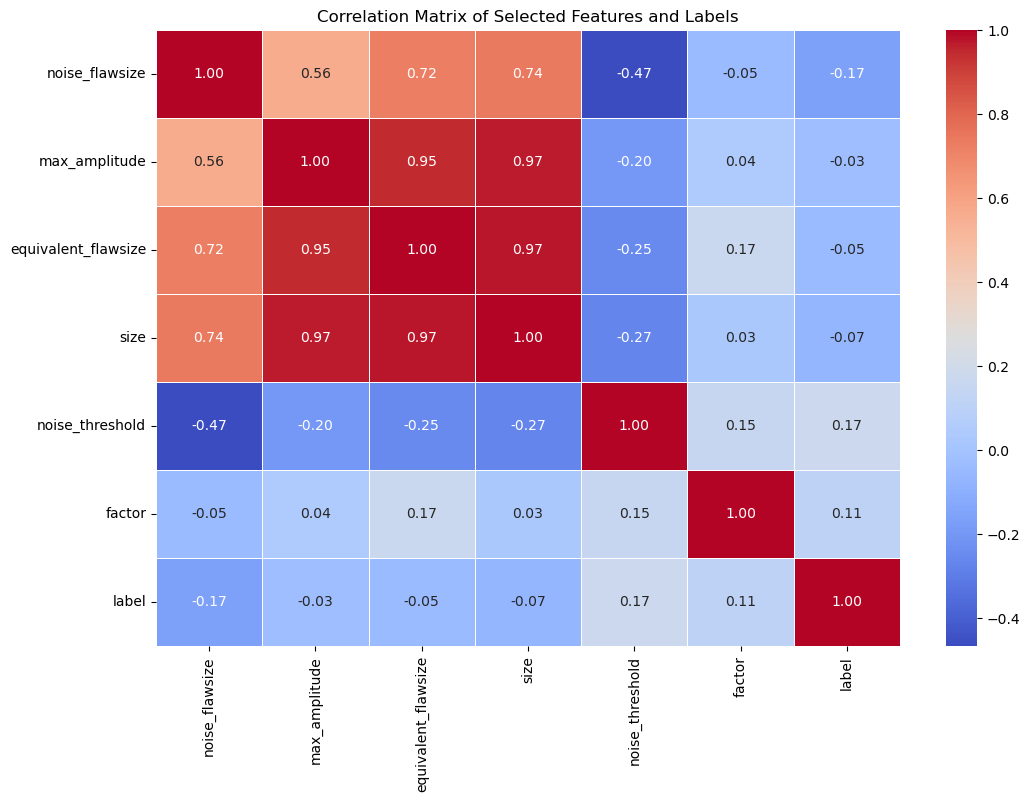

In [18]:
import seaborn as sns
# Array for selecting only the desired numeric columns (you can specify the columns you want here)
selected_features = ['noise_flawsize', 'max_amplitude', 'equivalent_flawsize', 'size', 'noise_threshold', 'factor']

# Filter json_df to keep only the selected numeric features
json_df_selected = json_df[selected_features]
json_df_selected = json_df_selected.apply(pd.to_numeric, errors='coerce')
# Combine with the labels from the labels_df
combined_df = pd.concat([json_df_selected, labels_df['label']], axis=1)

# Compute the correlation matrix, explicitly specifying numeric_only=True
corr_matrix = combined_df.corr(numeric_only=True)

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Selected Features and Labels")
plt.show()



In [19]:
# Define an array with the column names you want to use as features
selected_columns = ['noise_flawsize', 'max_amplitude', 'equivalent_flawsize', 'size', 'noise_threshold', 'factor']  # Example column names

# Filter json_df to include only the selected columns
X_selected = json_df[selected_columns].apply(pd.to_numeric, errors='coerce')

# Ensure the selected columns exist in json_df
assert all(col in json_df.columns for col in selected_columns), "Some selected columns are missing in json_df."

# Now X_selected will contain only the columns you want to use as features
X = X_selected  # Update X to only contain the selected features
y = labels_df['label']  # Labels from the .labels file

# Handle missing values (if any) in the selected columns
X = X.fillna(X.mean())  # Filling missing values with the column mean (example)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.71      0.77      0.74        13

    accuracy                           0.65        20
   macro avg       0.61      0.60      0.60        20
weighted avg       0.64      0.65      0.64        20

Accuracy: 0.6500


In [20]:
# Assuming json_df is the DataFrame containing the features from the JSON file
# And labels_df contains the corresponding labels in the 'label' column

# Step 1: Feature Selection
# You can choose the columns you want from json_df based on domain knowledge or initial experimentation.
selected_columns = ['noise_flawsize', 'max_amplitude', 'equivalent_flawsize', 'size', 'factor']  # Example, replace with actual columns
X = json_df[selected_columns].apply(pd.to_numeric, errors='coerce')

# Step 2: Handling Missing Data
# Impute missing values if necessary
imputer = SimpleImputer(strategy='mean')  # You can use 'median' or 'most_frequent' if more appropriate
X_imputed = imputer.fit_transform(X)

# Step 3: Scaling Features (optional, not needed for RandomForest, but useful for other models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 4: Handling Class Imbalance by adjusting class weights
y = labels_df['label']  # Assuming 'label' is the column in labels_df with your class labels

# Step 5: Splitting Data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Hyperparameter Tuning (optional but recommended)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = RandomForestClassifier(random_state=42)

# Grid Search for Best Hyperparameters
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")
clf = grid_search.best_estimator_

# Step 7: Model Training
clf.fit(X_train, y_train)

# Step 8: Model Evaluation
y_pred = clf.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Step 9: Cross-Validation (Optional)
cross_val_scores = cross_val_score(clf, X_scaled, y, cv=5)
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Average cross-validation score: {cross_val_scores.mean():.4f}")


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.43      0.40         7
           1       0.67      0.62      0.64        13

    accuracy                           0.55        20
   macro avg       0.52      0.52      0.52        20
weighted avg       0.56      0.55      0.56        20

Accuracy: 0.5500
Cross-validation scores: [0.7  0.5  0.6  0.7  0.55]
Average cross-validation score: 0.6100


In [21]:
# Read the corresponding .labels file
def read_labels(labels_path):
    # Read the .labels file assuming no headers and the first column as numbers (0-99) and the second column as the labels (0 or 1)
    labels_df = pd.read_csv(labels_path, header=None, delim_whitespace=True)
    labels_df.columns = ['Label', 'flaw size in label']
    return labels_df

# Read a .jsons file and convert it to a dataframe
def read_jsons(json_path):
    with open(json_path, 'r') as file:
        content = file.read()

    # Fix the JSON content and parse
    fixed_content = '[' + content.replace('}{', '},{') + ']'
    flaws_data = json.loads(fixed_content)

    # Flatten the data and convert it to a dataframe
    json_df = pd.json_normalize(flaws_data, 'flaws')
    return json_df

# Load multiple .jsons and .labels files
json_files = [f for f in os.listdir(training_data_path) if f.endswith('.jsons')]
labels_files = [f.replace('.jsons', '.labels') for f in json_files]

# Initialize lists to hold the dataframes
json_dfs = []
labels_dfs = []

# Read and append the data
for json_file, labels_file in zip(json_files, labels_files):
    json_path = os.path.join(training_data_path, json_file)
    labels_path = os.path.join(training_data_path, labels_file)
    
    json_df = read_jsons(json_path)
    labels_df = read_labels(labels_path)
    
    json_dfs.append(json_df)
    labels_dfs.append(labels_df)

# Concatenate all json dataframes and labels dataframes
combined_json_df = pd.concat(json_dfs, ignore_index=True)
combined_labels_df = pd.concat(labels_dfs, ignore_index=True)

# Select specific features from the json_df (you can update this array based on your selection)
selected_columns = ['noise_flawsize', 'max_amplitude', 'equivalent_flawsize', 'size', 'factor']  # Update with actual column names

# Ensure the features are numeric
json_selected_df = combined_json_df[selected_columns].apply(pd.to_numeric, errors='coerce')

# Combine the selected features with the labels
final_df = pd.concat([json_selected_df, combined_labels_df['Label']], axis=1)

# Split the data into features and labels
X = final_df.drop('Label', axis=1)
y = final_df['Label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a RandomForestClassifier
clf = RandomForestClassifier()

# Train the model
clf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Optional: Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

# Evaluate with best parameters
best_clf = grid_search.best_estimator_
y_pred_best = best_clf.predict(X_test)
print(classification_report(y_test, y_pred_best))
print("Accuracy:", accuracy_score(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1543
           1       1.00      1.00      1.00      2419

    accuracy                           1.00      3962
   macro avg       1.00      1.00      1.00      3962
weighted avg       1.00      1.00      1.00      3962

Accuracy: 1.0
Best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1543
           1       1.00      1.00      1.00      2419

    accuracy                           1.00      3962
   macro avg       1.00      1.00      1.00      3962
weighted avg       1.00      1.00      1.00      3962

Accuracy: 1.0


In [22]:
final_df

,noise_flawsize,max_amplitude,equivalent_flawsize,size,factor,Label
0,0.213404,6028,1.346065,1.6,0.816865,1
1,0.000000,3734,0.000000,0.0,0.508784,0
2,0.336687,23474,5.826761,8.6,0.664391,1
3,0.000000,3734,0.000000,0.0,0.888821,0
4,0.336687,23474,7.232326,8.6,0.834488,1
...,...,...,...,...,...,...
19805,0.213404,6028,1.456241,1.6,0.896323,1
19806,0.503912,7414,3.915938,4.0,0.975956,1
19807,0.213404,6028,1.515584,1.6,0.939120,1
19808,0.000000,3734,0.000000,0.0,0.820856,0


In [23]:
# Read the corresponding .labels file
def read_labels(labels_path):
    labels_df = pd.read_csv(labels_path, header=None, delim_whitespace=True)
    labels_df.columns = ['Label', 'flaw size in label']
    return labels_df

# Read a .jsons file and convert it to a dataframe
def read_jsons(json_path):
    with open(json_path, 'r') as file:
        content = file.read()

    # Fix the JSON content and parse
    fixed_content = '[' + content.replace('}{', '},{') + ']'
    flaws_data = json.loads(fixed_content)

    # Flatten the data and convert it to a dataframe
    json_df = pd.json_normalize(flaws_data, 'flaws')
    return json_df

# Load validation .jsons and .labels files
validation_json_files = [f for f in os.listdir(validation_data_path) if f.endswith('.jsons')]
validation_labels_files = [f.replace('.jsons', '.labels') for f in validation_json_files]

# Initialize lists to hold the dataframes for validation
validation_json_dfs = []
validation_labels_dfs = []

# Read and append the validation data
for json_file, labels_file in zip(validation_json_files, validation_labels_files):
    json_path = os.path.join(validation_data_path, json_file)
    labels_path = os.path.join(validation_data_path, labels_file)
    
    json_df = read_jsons(json_path)
    labels_df = read_labels(labels_path)
    
    validation_json_dfs.append(json_df)
    validation_labels_dfs.append(labels_df)

# Concatenate all validation json dataframes and labels dataframes
validation_json_df = pd.concat(validation_json_dfs, ignore_index=True)
validation_labels_df = pd.concat(validation_labels_dfs, ignore_index=True)

# Select specific features from the json_df (same as before, can adjust as needed)
selected_columns = ['noise_flawsize', 'max_amplitude', 'equivalent_flawsize', 'size', 'factor']  # Update with actual column names

# Ensure the features are numeric
validation_selected_df = validation_json_df[selected_columns].apply(pd.to_numeric, errors='coerce')

# Combine the selected features with the validation labels
validation_final_df = pd.concat([validation_selected_df, validation_labels_df['Label']], axis=1)

# Separate features and labels for validation
X_validation = validation_final_df.drop('Label', axis=1)
y_validation = validation_final_df['Label']

# Use the best model from grid search or the default trained model
y_validation_pred = best_clf.predict(X_validation)

# Evaluate the model's performance on the validation set
print("Classification Report for Validation Data:")
print(classification_report(y_validation, y_validation_pred))
print("Accuracy on Validation Data:", accuracy_score(y_validation, y_validation_pred))



Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00       111

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy on Validation Data: 1.0


In [24]:
validation_final_df

,noise_flawsize,max_amplitude,equivalent_flawsize,size,factor,Label
0,0.000000,4050,0.000000,0.0,0.824421,0
1,0.213404,6028,1.164799,1.6,0.686137,1
2,0.336687,23474,6.246028,8.6,0.715130,1
3,0.000000,4050,0.000000,0.0,0.534994,0
4,0.503912,7414,3.907191,4.0,0.973454,1
...,...,...,...,...,...,...
195,0.000000,4050,0.000000,0.0,0.889834,0
196,0.213404,6028,1.260623,1.6,0.755245,1
197,0.213404,6028,1.559573,1.6,0.970844,1
198,0.213404,6028,1.501814,1.6,0.929189,1
